In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import zipfile
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pylab

In [20]:
import keras
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten
from keras.models import Sequential

In [2]:
!unzip "/content/drive/MyDrive/cats_and_dogs_filtered.zip" -d "/content/drive/MyDrive/cats_and_dogs_filtered"

Archive:  /content/drive/MyDrive/cats_and_dogs_filtered.zip
replace /content/drive/MyDrive/cats_and_dogs_filtered/cats_and_dogs_filtered/vectorize.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/drive/MyDrive/cats_and_dogs_filtered/cats_and_dogs_filtered/vectorize.py  
  inflating: /content/drive/MyDrive/cats_and_dogs_filtered/cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: /content/drive/MyDrive/cats_and_dogs_filtered/cats_and_dogs_filtered/validation/dogs/dog.2126.jpg  
  inflating: /content/drive/MyDrive/cats_and_dogs_filtered/cats_and_dogs_filtered/validation/dogs/dog.2125.jpg  
  inflating: /content/drive/MyDrive/cats_and_dogs_filtered/cats_and_dogs_filtered/validation/dogs/dog.2124.jpg  
  inflating: /content/drive/MyDrive/cats_and_dogs_filtered/cats_and_dogs_filtered/validation/dogs/dog.2123.jpg  
  inflating: /content/drive/MyDrive/cats_and_dogs_filtered/cats_and_dogs_filtered/validation/dogs/dog.2122.jpg  
  inflating: /content/drive/MyDriv

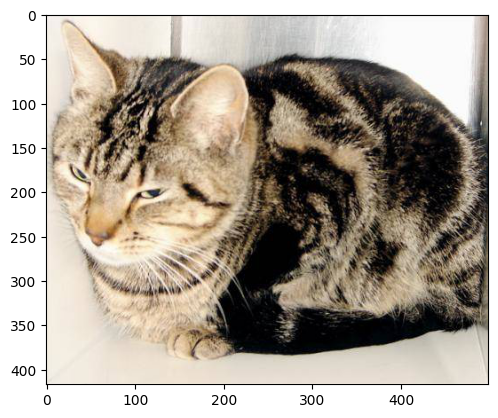

In [3]:
import matplotlib.pyplot as plt
im = plt.imread('/content/drive/MyDrive/cats_and_dogs_filtered/cats_and_dogs_filtered/train/cats/cat.897.jpg')
plt.imshow(im)
plt.show()

In [4]:
!pip install split-folders

In [6]:
import splitfolders
splitfolders.ratio("/content/drive/MyDrive/cats_and_dogs_filtered/cats_and_dogs_filtered/train",output = "output",seed = 1337,ratio = (.8, .2))

Copying files: 2000 files [00:08, 240.64 files/s]


Load datas

In [7]:
split=0.2
seed=19260817
batch_size=256
img_size=(224,224)

train_ds = keras.utils.image_dataset_from_directory(
    '/content/output/train',
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=seed,
    validation_split=split,
    subset='training',
)
val_ds = keras.utils.image_dataset_from_directory(
    '/content/output/train',
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=seed,
    validation_split=split,
    subset='validation',
)

Found 1600 files belonging to 2 classes.
Using 1280 files for training.
Found 1600 files belonging to 2 classes.
Using 320 files for validation.


<ipython-input-8-6046dea0c6eb>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 4,i+1)


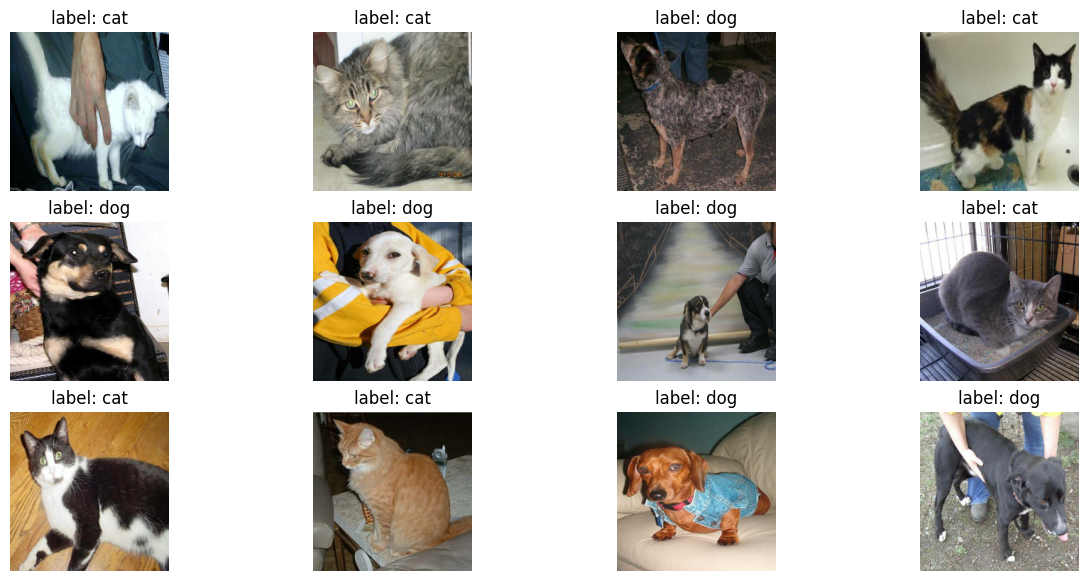

In [8]:
label_names={0:'cat',1:'dog'}

fig, ax = plt.subplots(figsize=(15, 7))
for img, label in train_ds.take(1):
    for i in range(12):
        plt.subplot(3, 4,i+1)
        plt.imshow(img.numpy()[i]/255)
        plt.axis("off")
        plt.title("label: "+label_names[label.numpy()[i]])
        #rint("label:", label.numpy()[i])
plt.show()

 load VGG model

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_history(history,title=''):
    if title!='':
        title+=' '
    #Ploting the Loss and Accuracy Curves
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16,6))
    #Loss
    sns.lineplot(data = history.history['loss'], label = 'Training Loss', ax = ax[0])
    sns.lineplot(data = history.history['val_loss'], label = 'Validation Loss', ax = ax[0])
    ax[0].legend(loc = 'upper right')
    ax[0].set_title(title+'Loss')
    #Accuracy
    sns.lineplot(data = history.history['accuracy'], label = 'Training Accuracy', ax = ax[1])
    sns.lineplot(data = history.history['val_accuracy'], label = 'Validation Accuracy', ax = ax[1])
    ax[1].legend(loc = 'lower right')
    ax[1].set_title(title+'Accuracy')

 augmentation

In [10]:
data_augmentation = keras.Sequential(
    [
        #layers.RandomFlip("horizontal"),
        #layers.RandomRotation(0.2),
        #layers.RandomTranslation(0.14,0.14),
        #layers.RandomZoom(0.2),
        #layers.RandomContrast(0.2),
    ]
)

callback

In [11]:
CB = [
            keras.callbacks.ModelCheckpoint(
            filepath="fine_tuning.keras",
            save_best_only=True,
            monitor="val_loss"),

            keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0.0005,
            patience=10)
]

vgg16 model

In [12]:
vgg16_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    #weights=None,
    include_top=False)

#vgg16_base.trainable = True
vgg16_base.trainable = False

print("This is the number of trainable weights "
      "before freezing the conv base:", len(vgg16_base.trainable_weights))

vgg16_base.summary()

58889256/58889256 [==============================] - 2s 0us/step
This is the number of trainable weights before freezing the conv base: 0
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   

In [13]:
inputs = keras.Input(shape=img_size+(3,))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = vgg16_base(x)
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256,activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256,activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256,activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256,activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation="softmax")(x)
vgg16_model = keras.Model(inputs, outputs)
vgg16_model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
vgg16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     multiple                  0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                             

In [14]:
history_vgg16 = vgg16_model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=CB
    )
vgg16_model = keras.models.load_model("fine_tuning.keras")

Epoch 1/100
5/5 [==============================] - 56s 3s/step - loss: 0.6478 - accuracy: 0.7195 - val_loss: 0.2400 - val_accuracy: 0.9531
Epoch 2/100
5/5 [==============================] - 10s 1s/step - loss: 0.2300 - accuracy: 0.9164 - val_loss: 0.3370 - val_accuracy: 0.9438
Epoch 3/100
5/5 [==============================] - 9s 2s/step - loss: 0.1044 - accuracy: 0.9625 - val_loss: 0.3260 - val_accuracy: 0.9625
Epoch 4/100
5/5 [==============================] - 9s 2s/step - loss: 0.0619 - accuracy: 0.9758 - val_loss: 0.2853 - val_accuracy: 0.9688
Epoch 5/100
5/5 [==============================] - 8s 1s/step - loss: 0.0245 - accuracy: 0.9945 - val_loss: 0.2466 - val_accuracy: 0.9719
Epoch 6/100
5/5 [==============================] - 10s 1s/step - loss: 0.0206 - accuracy: 0.9937 - val_loss: 0.2112 - val_accuracy: 0.9719
Epoch 7/100
5/5 [==============================] - 9s 2s/step - loss: 0.0115 - accuracy: 0.9953 - val_loss: 0.1799 - val_accuracy: 0.9719
Epoch 8/100
5/5 [==============

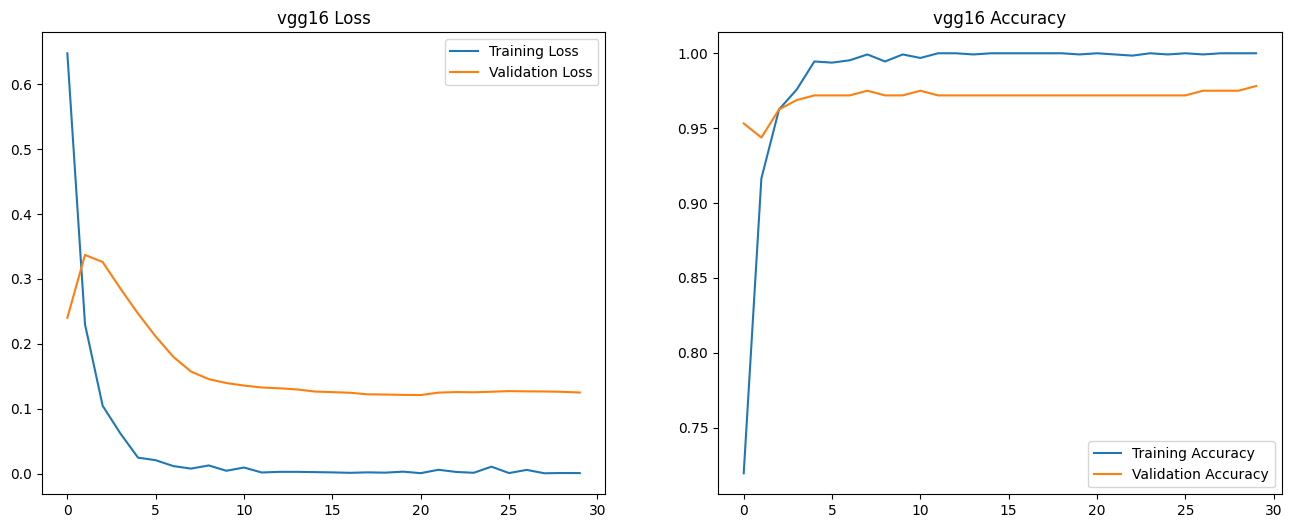

In [15]:
plot_history(history_vgg16,'vgg16')

vgg19 model

In [16]:
vgg19_base  = keras.applications.vgg19.VGG19(
    weights="imagenet",
    include_top=False)

#vgg19_base.trainable = True
vgg19_base.trainable = False


print("This is the number of trainable weights "
      "before freezing the conv base:", len(vgg19_base.trainable_weights))

vgg19_base.summary()

80134624/80134624 [==============================] - 3s 0us/step
This is the number of trainable weights before freezing the conv base: 0
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   

In [17]:
inputs = keras.Input(shape=img_size+(3,))
x = data_augmentation(inputs)
x = keras.applications.vgg19.preprocess_input(x)
x = vgg19_base(x)
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256,activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256,activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256,activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256,activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation="softmax")(x)
vgg19_model = keras.Model(inputs, outputs)
vgg19_model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
vgg16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     multiple                  0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                             

In [18]:
history_vgg19 = vgg19_model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=CB
    )
vgg19_model = keras.models.load_model("fine_tuning.keras")

Epoch 1/100
5/5 [==============================] - 15s 2s/step - loss: 0.5135 - accuracy: 0.7961 - val_loss: 0.3277 - val_accuracy: 0.9281
Epoch 2/100
5/5 [==============================] - 10s 2s/step - loss: 0.1179 - accuracy: 0.9586 - val_loss: 0.6828 - val_accuracy: 0.8875
Epoch 3/100
5/5 [==============================] - 10s 2s/step - loss: 0.0618 - accuracy: 0.9812 - val_loss: 0.2003 - val_accuracy: 0.9594
Epoch 4/100
5/5 [==============================] - 10s 2s/step - loss: 0.0365 - accuracy: 0.9859 - val_loss: 0.1291 - val_accuracy: 0.9688
Epoch 5/100
5/5 [==============================] - 10s 2s/step - loss: 0.0141 - accuracy: 0.9969 - val_loss: 0.1488 - val_accuracy: 0.9625
Epoch 6/100
5/5 [==============================] - 10s 2s/step - loss: 0.0185 - accuracy: 0.9969 - val_loss: 0.1337 - val_accuracy: 0.9750
Epoch 7/100
5/5 [==============================] - 11s 2s/step - loss: 0.0082 - accuracy: 0.9977 - val_loss: 0.1048 - val_accuracy: 0.9781
Epoch 8/100
5/5 [==========

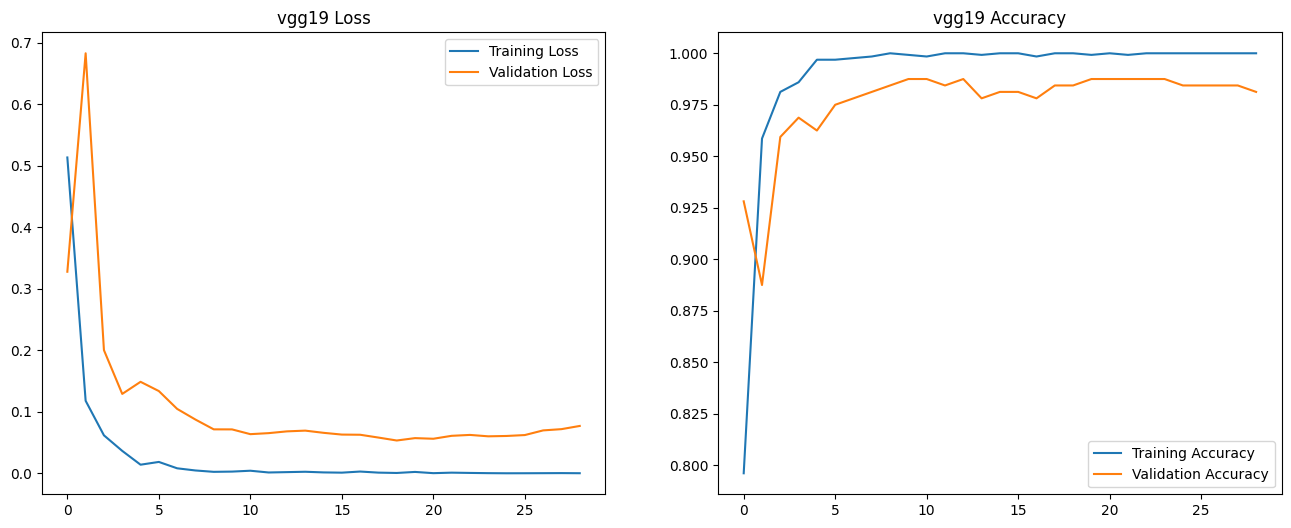

In [19]:
plot_history(history_vgg19,'vgg19')

LeNet

In [95]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.utils.vis_utils import plot_model

In [96]:
labels = ["cats", "dogs"]
classNameslabels = {labels: i for i, labels in enumerate(labels)}

In [97]:
print(classNameslabels)

{'cats': 0, 'dogs': 1}


In [105]:
import pandas as pd
from pathlib import Path
import os

train_image_path=Path("/content/output/train")
image_path=list(train_image_path.glob(r"**/*.jpg"))
image_label=list(map(lambda x:os.path.split(os.path.split(x)[0])[1],image_path))
final_data = pd.DataFrame({'data':image_path, 'label':image_label}).astype('str')

In [106]:
final_data

,data,label
0,/content/output/train/cats/cat.838.jpg,cats
1,/content/output/train/cats/cat.329.jpg,cats
2,/content/output/train/cats/cat.477.jpg,cats
3,/content/output/train/cats/cat.758.jpg,cats
4,/content/output/train/cats/cat.184.jpg,cats
...,...,...
1595,/content/output/train/dogs/dog.55.jpg,dogs
1596,/content/output/train/dogs/dog.690.jpg,dogs
1597,/content/output/train/dogs/dog.805.jpg,dogs
1598,/content/output/train/dogs/dog.481.jpg,dogs


In [107]:
final_data =final_data.sample(frac=1).reset_index(drop=True)

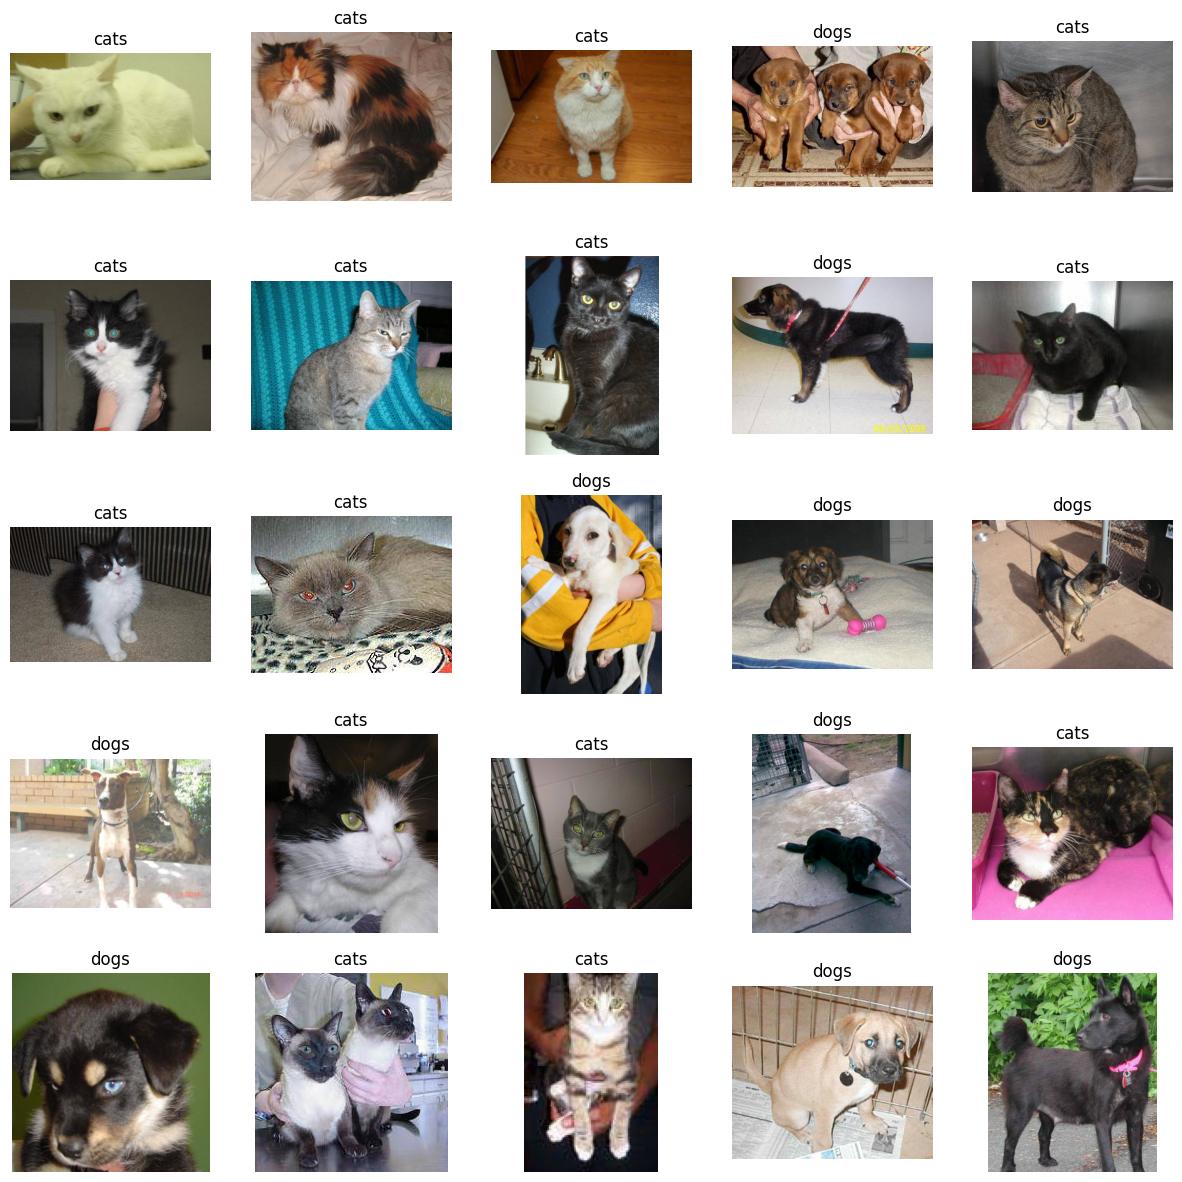

In [108]:
plt.figure(figsize=(15,15))
num_img=(5,5)
for i in range(1,(num_img[0]*num_img[1])+1):
    plt.subplot(num_img[0],num_img[1],i)
    plt.axis("off")
    plt.title(final_data["label"][i])
    plt.imshow(plt.imread(final_data["data"][i]))

In [110]:
image_shape=28
def datasetLoaderFromDirectory():
        dataset_path = ["/content/output/train", "/content/output/val"]
        imageataOutput = []

        for i in dataset_path:
            images = []
            labels = []
            print("Counting : {}".format(i))

            for j in os.listdir(i):
                label = classNameslabels[j]

                for imagedatafile in tqdm(os.listdir(os.path.join(i, j))):

                    imagePath = os.path.join(os.path.join(i, j), imagedatafile)

                    image = cv2.imread(imagePath)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image,(image_shape,image_shape))

                    images.append(image)
                    labels.append(label)
            images = np.array(images)
            labels = np.array(labels)
            #print(images)
            imageataOutput.append((images, labels))

        return imageataOutput

In [114]:
from tqdm import tqdm
import cv2

In [115]:
(train_image, train_labels), (test_image, test_labels) = datasetLoaderFromDirectory()

Counting : /content/output/train


100%|██████████| 800/800 [00:02<00:00, 295.41it/s]


Counting : /content/output/val


100%|██████████| 200/200 [00:00<00:00, 295.90it/s]


In [117]:
from sklearn.utils import shuffle
train_image, train_labels = shuffle(train_image, train_labels, random_state = 101)

In [124]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
label_Encoder = LabelEncoder()
#label_Encoder = preprocessing.LabelEncoder
ytrain = label_Encoder.fit_transform(train_labels)
ytest = label_Encoder.fit_transform(test_labels)

In [131]:
#OneHotEncoder for train dataset
labelEncoderValue=ytrain.reshape(len(ytrain),1)
ohe=OneHotEncoder(sparse=False)
Ytrain=ohe.fit_transform(labelEncoderValue)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [132]:
#OneHotEncoder for test dataset
labelEncoderValue=ytest.reshape(len(ytest),1)
ohe=OneHotEncoder(sparse=False)
y_test=ohe.fit_transform(labelEncoderValue)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [133]:
Ytrain.shape

(1600, 2)

In [125]:
model = Sequential() # Empty

# 1st layer
model.add(Conv2D(6,kernel_size = (5, 5), strides = (1, 1), activation = "relu", input_shape = (28, 28, 3), padding = "same"))
model.add(AveragePooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid"))

# 2nd Layer
model.add(Conv2D(16,kernel_size = (5, 5), strides = (1, 1), activation = "relu", padding = "valid"))
model.add(AveragePooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid"))

# Flatten Layer
model.add(Flatten())

# Output Layer
model.add(Dense(120, activation = "relu"))
model.add(Dense(84, activation = "relu"))
model.add(Dense(2, activation = "softmax"))

In [126]:
model.compile(optimizer = "adam",
             loss = "categorical_crossentropy",
             metrics = ["accuracy"])

In [127]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 28, 28, 6)         456       
                                                                 
 average_pooling2d_14 (Avera  (None, 14, 14, 6)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_24 (Conv2D)          (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_15 (Avera  (None, 5, 5, 16)         0         
 gePooling2D)                                                    
                                                                 
 flatten_10 (Flatten)        (None, 400)               0         
                                                                 
 dense_29 (Dense)            (None, 120)             

In [128]:
tensorboard=TensorBoard(log_dir="logs")
checkpoint=ModelCheckpoint("LeNet.h5",
                          monitor='val_accuracy',
                          mode="auto",
                          verbose=1,
                          save_best_only=True
                          )

reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',
                           factor=0.1,
                            patience=10,
                            min_delta=0.001,
                            mode="auto",
                            verbose=1
                           )
earlyStopping = EarlyStopping(monitor='val_acc',
                             patience=5,
                             verbose=1,
                             mode='auto')

In [134]:
history = model.fit(train_image,
                   Ytrain,
                   batch_size=32,
                   epochs=50,
                   verbose=1,
                   validation_split=0.2,
                   callbacks=[tensorboard, checkpoint, reduce_LR, earlyStopping]
                   )

Epoch 1/50
34/40 [========================>.....] - ETA: 0s - loss: 0.9841 - accuracy: 0.5423
Epoch 1: val_accuracy improved from -inf to 0.56250, saving model to LeNet.h5


40/40 [==============================] - 6s 12ms/step - loss: 0.9400 - accuracy: 0.5609 - val_loss: 0.7090 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 2/50
36/40 [==========================>...] - ETA: 0s - loss: 0.6275 - accuracy: 0.6632
Epoch 2: val_accuracy improved from 0.56250 to 0.59688, saving model to LeNet.h5


40/40 [==============================] - 0s 7ms/step - loss: 0.6295 - accuracy: 0.6625 - val_loss: 0.7087 - val_accuracy: 0.5969 - lr: 0.0010
Epoch 3/50
34/40 [========================>.....] - ETA: 0s - loss: 0.5840 - accuracy: 0.6884
Epoch 3: val_accuracy improved from 0.59688 to 0.62500, saving model to LeNet.h5


40/40 [==============================] - 0s 8ms/step - loss: 0.5887 - accuracy: 0.6852 - val_loss: 0.7000 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/50
36/40 [==========================>...] - ETA: 0s - loss: 0.5278 - accuracy: 0.7387
Epoch 4: val_accuracy did not improve from 0.62500


40/40 [==============================] - 0s 6ms/step - loss: 0.5259 - accuracy: 0.7406 - val_loss: 0.7098 - val_accuracy: 0.6062 - lr: 0.0010
Epoch 5/50
33/40 [=======================>......] - ETA: 0s - loss: 0.4560 - accuracy: 0.7831
Epoch 5: val_accuracy did not improve from 0.62500


40/40 [==============================] - 0s 7ms/step - loss: 0.4611 - accuracy: 0.7844 - val_loss: 0.7747 - val_accuracy: 0.6062 - lr: 0.0010
Epoch 6/50
32/40 [=======================>......] - ETA: 0s - loss: 0.3833 - accuracy: 0.8281
Epoch 6: val_accuracy did not improve from 0.62500


40/40 [==============================] - 0s 7ms/step - loss: 0.3945 - accuracy: 0.8242 - val_loss: 0.8860 - val_accuracy: 0.6156 - lr: 0.0010
Epoch 7/50
35/40 [=========================>....] - ETA: 0s - loss: 0.3519 - accuracy: 0.8446
Epoch 7: val_accuracy did not improve from 0.62500


40/40 [==============================] - 0s 6ms/step - loss: 0.3553 - accuracy: 0.8398 - val_loss: 0.8950 - val_accuracy: 0.6187 - lr: 0.0010
Epoch 8/50
33/40 [=======================>......] - ETA: 0s - loss: 0.2817 - accuracy: 0.8845
Epoch 8: val_accuracy did not improve from 0.62500


40/40 [==============================] - 0s 6ms/step - loss: 0.2886 - accuracy: 0.8797 - val_loss: 1.0616 - val_accuracy: 0.6187 - lr: 0.0010
Epoch 9/50
37/40 [==========================>...] - ETA: 0s - loss: 0.2245 - accuracy: 0.9155
Epoch 9: val_accuracy did not improve from 0.62500


40/40 [==============================] - 0s 7ms/step - loss: 0.2287 - accuracy: 0.9117 - val_loss: 0.9943 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 10/50
39/40 [============================>.] - ETA: 0s - loss: 0.1885 - accuracy: 0.9319
Epoch 10: val_accuracy did not improve from 0.62500


40/40 [==============================] - 0s 6ms/step - loss: 0.1877 - accuracy: 0.9328 - val_loss: 1.3899 - val_accuracy: 0.6219 - lr: 0.0010
Epoch 11/50
34/40 [========================>.....] - ETA: 0s - loss: 0.1474 - accuracy: 0.9494
Epoch 11: val_accuracy did not improve from 0.62500


40/40 [==============================] - 0s 6ms/step - loss: 0.1555 - accuracy: 0.9461 - val_loss: 1.2782 - val_accuracy: 0.5969 - lr: 0.0010
Epoch 12/50
32/40 [=======================>......] - ETA: 0s - loss: 0.1277 - accuracy: 0.9570
Epoch 12: val_accuracy improved from 0.62500 to 0.62813, saving model to LeNet.h5


40/40 [==============================] - 0s 8ms/step - loss: 0.1222 - accuracy: 0.9602 - val_loss: 1.4426 - val_accuracy: 0.6281 - lr: 0.0010
Epoch 13/50
38/40 [===========================>..] - ETA: 0s - loss: 0.0929 - accuracy: 0.9745
Epoch 13: val_accuracy did not improve from 0.62813


40/40 [==============================] - 0s 6ms/step - loss: 0.0941 - accuracy: 0.9742 - val_loss: 1.5730 - val_accuracy: 0.6219 - lr: 0.0010
Epoch 14/50
38/40 [===========================>..] - ETA: 0s - loss: 0.0827 - accuracy: 0.9737
Epoch 14: val_accuracy did not improve from 0.62813


40/40 [==============================] - 0s 7ms/step - loss: 0.0808 - accuracy: 0.9750 - val_loss: 1.7846 - val_accuracy: 0.5969 - lr: 0.0010
Epoch 15/50
34/40 [========================>.....] - ETA: 0s - loss: 0.0823 - accuracy: 0.9761
Epoch 15: val_accuracy did not improve from 0.62813


40/40 [==============================] - 0s 6ms/step - loss: 0.0782 - accuracy: 0.9797 - val_loss: 1.7139 - val_accuracy: 0.6281 - lr: 0.0010
Epoch 16/50
34/40 [========================>.....] - ETA: 0s - loss: 0.0443 - accuracy: 0.9899
Epoch 16: val_accuracy improved from 0.62813 to 0.63437, saving model to LeNet.h5


40/40 [==============================] - 0s 7ms/step - loss: 0.0435 - accuracy: 0.9914 - val_loss: 1.9039 - val_accuracy: 0.6344 - lr: 0.0010
Epoch 17/50
33/40 [=======================>......] - ETA: 0s - loss: 0.0419 - accuracy: 0.9858
Epoch 17: val_accuracy did not improve from 0.63437


40/40 [==============================] - 0s 7ms/step - loss: 0.0425 - accuracy: 0.9852 - val_loss: 2.3213 - val_accuracy: 0.6156 - lr: 0.0010
Epoch 18/50
37/40 [==========================>...] - ETA: 0s - loss: 0.0455 - accuracy: 0.9907
Epoch 18: val_accuracy did not improve from 0.63437


40/40 [==============================] - 0s 7ms/step - loss: 0.0608 - accuracy: 0.9867 - val_loss: 2.7597 - val_accuracy: 0.5875 - lr: 0.0010
Epoch 19/50
37/40 [==========================>...] - ETA: 0s - loss: 0.2197 - accuracy: 0.9088
Epoch 19: val_accuracy did not improve from 0.63437


40/40 [==============================] - 0s 6ms/step - loss: 0.2172 - accuracy: 0.9125 - val_loss: 1.4564 - val_accuracy: 0.6187 - lr: 0.0010
Epoch 20/50
33/40 [=======================>......] - ETA: 0s - loss: 0.0992 - accuracy: 0.9725
Epoch 20: val_accuracy did not improve from 0.63437


40/40 [==============================] - 0s 7ms/step - loss: 0.0917 - accuracy: 0.9750 - val_loss: 1.7074 - val_accuracy: 0.6344 - lr: 0.0010
Epoch 21/50
34/40 [========================>.....] - ETA: 0s - loss: 0.0297 - accuracy: 0.9945
Epoch 21: val_accuracy did not improve from 0.63437


40/40 [==============================] - 0s 6ms/step - loss: 0.0282 - accuracy: 0.9945 - val_loss: 1.8442 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 22/50
36/40 [==========================>...] - ETA: 0s - loss: 0.0182 - accuracy: 0.9957
Epoch 22: val_accuracy did not improve from 0.63437


40/40 [==============================] - 0s 6ms/step - loss: 0.0179 - accuracy: 0.9961 - val_loss: 2.2296 - val_accuracy: 0.6187 - lr: 0.0010
Epoch 23/50
39/40 [============================>.] - ETA: 0s - loss: 0.0056 - accuracy: 1.0000
Epoch 23: val_accuracy did not improve from 0.63437


40/40 [==============================] - 0s 7ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 2.2414 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 24/50
37/40 [==========================>...] - ETA: 0s - loss: 0.0031 - accuracy: 1.0000
Epoch 24: val_accuracy did not improve from 0.63437


40/40 [==============================] - 0s 6ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 2.3678 - val_accuracy: 0.6281 - lr: 0.0010
Epoch 25/50
34/40 [========================>.....] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000
Epoch 25: val_accuracy did not improve from 0.63437


40/40 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 2.5086 - val_accuracy: 0.6344 - lr: 0.0010
Epoch 26/50
34/40 [========================>.....] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000
Epoch 26: val_accuracy improved from 0.63437 to 0.63750, saving model to LeNet.h5


40/40 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 2.5655 - val_accuracy: 0.6375 - lr: 0.0010
Epoch 27/50
35/40 [=========================>....] - ETA: 0s - loss: 9.8365e-04 - accuracy: 1.0000
Epoch 27: val_accuracy improved from 0.63750 to 0.64062, saving model to LeNet.h5


40/40 [==============================] - 0s 7ms/step - loss: 9.6198e-04 - accuracy: 1.0000 - val_loss: 2.6209 - val_accuracy: 0.6406 - lr: 0.0010
Epoch 28/50
33/40 [=======================>......] - ETA: 0s - loss: 7.9004e-04 - accuracy: 1.0000
Epoch 28: val_accuracy improved from 0.64062 to 0.64375, saving model to LeNet.h5


40/40 [==============================] - 0s 11ms/step - loss: 7.9229e-04 - accuracy: 1.0000 - val_loss: 2.6756 - val_accuracy: 0.6438 - lr: 0.0010
Epoch 29/50
36/40 [==========================>...] - ETA: 0s - loss: 6.6903e-04 - accuracy: 1.0000
Epoch 29: val_accuracy did not improve from 0.64375


40/40 [==============================] - 0s 8ms/step - loss: 6.8395e-04 - accuracy: 1.0000 - val_loss: 2.7269 - val_accuracy: 0.6406 - lr: 0.0010
Epoch 30/50
40/40 [==============================] - ETA: 0s - loss: 6.0199e-04 - accuracy: 1.0000
Epoch 30: val_accuracy did not improve from 0.64375


40/40 [==============================] - 0s 9ms/step - loss: 6.0199e-04 - accuracy: 1.0000 - val_loss: 2.7592 - val_accuracy: 0.6438 - lr: 0.0010
Epoch 31/50
39/40 [============================>.] - ETA: 0s - loss: 5.2162e-04 - accuracy: 1.0000
Epoch 31: val_accuracy improved from 0.64375 to 0.64688, saving model to LeNet.h5


40/40 [==============================] - 0s 10ms/step - loss: 5.1943e-04 - accuracy: 1.0000 - val_loss: 2.8095 - val_accuracy: 0.6469 - lr: 0.0010
Epoch 32/50
38/40 [===========================>..] - ETA: 0s - loss: 4.7540e-04 - accuracy: 1.0000
Epoch 32: val_accuracy did not improve from 0.64688


40/40 [==============================] - 0s 8ms/step - loss: 4.6619e-04 - accuracy: 1.0000 - val_loss: 2.8387 - val_accuracy: 0.6469 - lr: 0.0010
Epoch 33/50
35/40 [=========================>....] - ETA: 0s - loss: 4.0312e-04 - accuracy: 1.0000
Epoch 33: val_accuracy did not improve from 0.64688


40/40 [==============================] - 0s 9ms/step - loss: 4.1309e-04 - accuracy: 1.0000 - val_loss: 2.8668 - val_accuracy: 0.6469 - lr: 0.0010
Epoch 34/50
40/40 [==============================] - ETA: 0s - loss: 3.7534e-04 - accuracy: 1.0000
Epoch 34: val_accuracy did not improve from 0.64688


40/40 [==============================] - 0s 10ms/step - loss: 3.7534e-04 - accuracy: 1.0000 - val_loss: 2.9014 - val_accuracy: 0.6469 - lr: 0.0010
Epoch 35/50
37/40 [==========================>...] - ETA: 0s - loss: 3.5362e-04 - accuracy: 1.0000
Epoch 35: val_accuracy did not improve from 0.64688


40/40 [==============================] - 0s 8ms/step - loss: 3.4168e-04 - accuracy: 1.0000 - val_loss: 2.9284 - val_accuracy: 0.6438 - lr: 0.0010
Epoch 36/50
40/40 [==============================] - ETA: 0s - loss: 3.1527e-04 - accuracy: 1.0000
Epoch 36: val_accuracy did not improve from 0.64688


40/40 [==============================] - 0s 8ms/step - loss: 3.1527e-04 - accuracy: 1.0000 - val_loss: 2.9555 - val_accuracy: 0.6469 - lr: 0.0010
Epoch 37/50
35/40 [=========================>....] - ETA: 0s - loss: 2.9189e-04 - accuracy: 1.0000
Epoch 37: val_accuracy did not improve from 0.64688


40/40 [==============================] - 0s 9ms/step - loss: 2.8689e-04 - accuracy: 1.0000 - val_loss: 2.9822 - val_accuracy: 0.6469 - lr: 0.0010
Epoch 38/50
38/40 [===========================>..] - ETA: 0s - loss: 2.6664e-04 - accuracy: 1.0000
Epoch 38: val_accuracy improved from 0.64688 to 0.65000, saving model to LeNet.h5


40/40 [==============================] - 0s 10ms/step - loss: 2.6369e-04 - accuracy: 1.0000 - val_loss: 3.0070 - val_accuracy: 0.6500 - lr: 0.0010
Epoch 39/50
37/40 [==========================>...] - ETA: 0s - loss: 2.5079e-04 - accuracy: 1.0000
Epoch 39: val_accuracy did not improve from 0.65000


40/40 [==============================] - 0s 7ms/step - loss: 2.4537e-04 - accuracy: 1.0000 - val_loss: 3.0360 - val_accuracy: 0.6500 - lr: 0.0010
Epoch 40/50
40/40 [==============================] - ETA: 0s - loss: 2.2933e-04 - accuracy: 1.0000
Epoch 40: val_accuracy improved from 0.65000 to 0.65312, saving model to LeNet.h5


40/40 [==============================] - 0s 6ms/step - loss: 2.2933e-04 - accuracy: 1.0000 - val_loss: 3.0502 - val_accuracy: 0.6531 - lr: 0.0010
Epoch 41/50
38/40 [===========================>..] - ETA: 0s - loss: 2.1323e-04 - accuracy: 1.0000
Epoch 41: val_accuracy improved from 0.65312 to 0.65625, saving model to LeNet.h5


40/40 [==============================] - 0s 6ms/step - loss: 2.1220e-04 - accuracy: 1.0000 - val_loss: 3.0777 - val_accuracy: 0.6562 - lr: 0.0010
Epoch 42/50
34/40 [========================>.....] - ETA: 0s - loss: 2.0373e-04 - accuracy: 1.0000
Epoch 42: val_accuracy did not improve from 0.65625


40/40 [==============================] - 0s 7ms/step - loss: 1.9781e-04 - accuracy: 1.0000 - val_loss: 3.0989 - val_accuracy: 0.6469 - lr: 0.0010
Epoch 43/50
38/40 [===========================>..] - ETA: 0s - loss: 1.8553e-04 - accuracy: 1.0000
Epoch 43: val_accuracy did not improve from 0.65625


40/40 [==============================] - 0s 7ms/step - loss: 1.8652e-04 - accuracy: 1.0000 - val_loss: 3.1126 - val_accuracy: 0.6531 - lr: 0.0010
Epoch 44/50
39/40 [============================>.] - ETA: 0s - loss: 1.7404e-04 - accuracy: 1.0000
Epoch 44: val_accuracy did not improve from 0.65625


40/40 [==============================] - 0s 6ms/step - loss: 1.7378e-04 - accuracy: 1.0000 - val_loss: 3.1364 - val_accuracy: 0.6500 - lr: 0.0010
Epoch 45/50
36/40 [==========================>...] - ETA: 0s - loss: 1.4848e-04 - accuracy: 1.0000
Epoch 45: val_accuracy did not improve from 0.65625


40/40 [==============================] - 0s 6ms/step - loss: 1.6400e-04 - accuracy: 1.0000 - val_loss: 3.1584 - val_accuracy: 0.6531 - lr: 0.0010
Epoch 46/50
35/40 [=========================>....] - ETA: 0s - loss: 1.5755e-04 - accuracy: 1.0000
Epoch 46: val_accuracy did not improve from 0.65625


40/40 [==============================] - 0s 7ms/step - loss: 1.5370e-04 - accuracy: 1.0000 - val_loss: 3.1769 - val_accuracy: 0.6531 - lr: 0.0010
Epoch 47/50
34/40 [========================>.....] - ETA: 0s - loss: 1.4820e-04 - accuracy: 1.0000
Epoch 47: val_accuracy did not improve from 0.65625


40/40 [==============================] - 0s 6ms/step - loss: 1.4461e-04 - accuracy: 1.0000 - val_loss: 3.1932 - val_accuracy: 0.6531 - lr: 0.0010
Epoch 48/50
34/40 [========================>.....] - ETA: 0s - loss: 1.3941e-04 - accuracy: 1.0000
Epoch 48: val_accuracy did not improve from 0.65625


40/40 [==============================] - 0s 6ms/step - loss: 1.3639e-04 - accuracy: 1.0000 - val_loss: 3.2094 - val_accuracy: 0.6531 - lr: 0.0010
Epoch 49/50
37/40 [==========================>...] - ETA: 0s - loss: 1.2743e-04 - accuracy: 1.0000
Epoch 49: val_accuracy improved from 0.65625 to 0.66250, saving model to LeNet.h5


40/40 [==============================] - 0s 8ms/step - loss: 1.2870e-04 - accuracy: 1.0000 - val_loss: 3.2306 - val_accuracy: 0.6625 - lr: 0.0010
Epoch 50/50
32/40 [=======================>......] - ETA: 0s - loss: 1.1593e-04 - accuracy: 1.0000
Epoch 50: val_accuracy did not improve from 0.66250


40/40 [==============================] - 0s 7ms/step - loss: 1.2220e-04 - accuracy: 1.0000 - val_loss: 3.2435 - val_accuracy: 0.6562 - lr: 0.0010


In [135]:
pred=model.predict(test_image)

13/13 [==============================] - 0s 6ms/step


In [140]:
def accuracy_and_loss_Plot(modelData):

    fig=plt.figure(figsize=(10,10))

    plt.subplot(221)
    plt.plot(modelData.history["accuracy"], 'bo--',label='accuracy')
    plt.plot(modelData.history["val_accuracy"],'ro--',label='val_accuracy')
    plt.title(" Accuracy Measurements")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy Information")
    #plt.grid()
    plt.legend()
    plt.tight_layout()

    plt.subplot(222)
    plt.plot(modelData.history["loss"], 'bo--',label='loss')
    plt.plot(modelData.history["val_loss"],'ro--',label='val_loss')
    plt.title("Loss Measurements")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss Information")
    #plt.grid()
    plt.legend()
    plt.tight_layout()

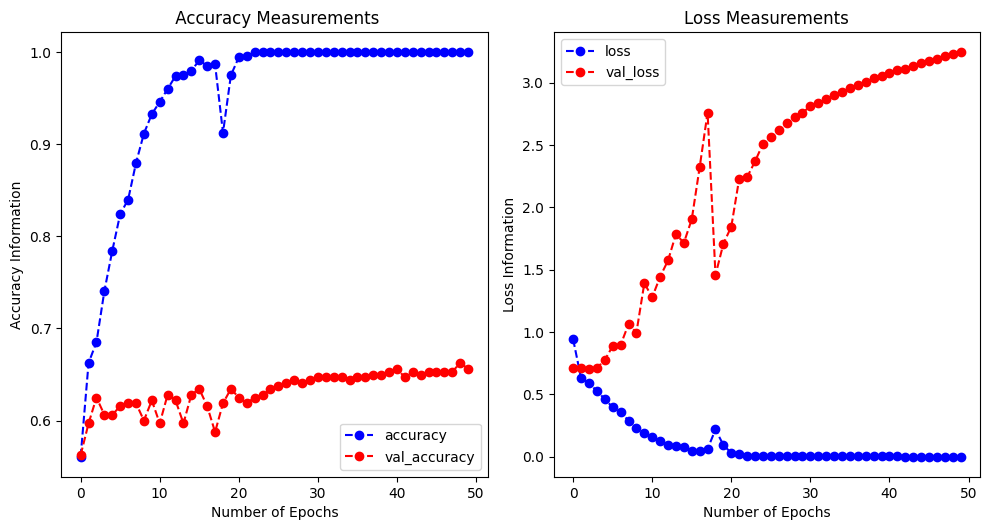

In [141]:
accuracy_and_loss_Plot(history)

Compare two models

In [139]:
vgg16_test=vgg16_model.evaluate(val_ds)
vgg19_test=vgg19_model.evaluate(val_ds)


2/2 [==============================] - 2s 277ms/step - loss: 0.0534 - accuracy: 0.9844
